#grescale image

In [ ]:
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Resize, ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

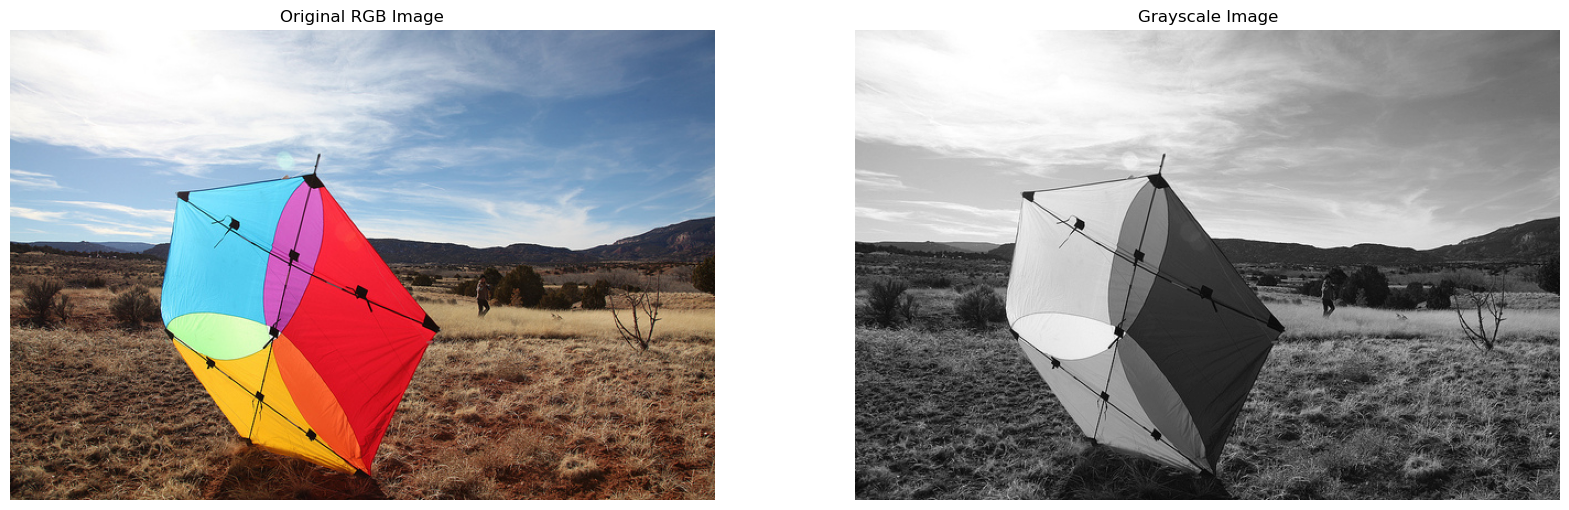

In [2]:
image_path = "C:/Users/hegde/Downloads/Dl assignment/train2017/000000572909.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
blue, green, red = image_rgb[:,:,0], image_rgb[:,:,1], image_rgb[:,:,2]
grayscale_img_wt = 0.2126 * red + 0.7152 * green + 0.0722 * blue
plt.figure(figsize=(20, 20))
fig = plt.figure(1)
img1, img2 = fig.add_subplot(121), fig.add_subplot(122)
img1.imshow(image_rgb)
img1.set_title('Original RGB Image')
img1.axis('off') 
img2.imshow(grayscale_img_wt, cmap='gray')
img2.set_title('Grayscale Image')
img2.axis('off') 
plt.show()

vae on greyscale image

Epoch 1/50, Loss: 45711.12109375
Epoch 2/50, Loss: 755936.5625
Epoch 3/50, Loss: 98145.671875
Epoch 4/50, Loss: 47964.2109375
Epoch 5/50, Loss: 44075.41015625
Epoch 6/50, Loss: 42043.8203125
Epoch 7/50, Loss: 38486.43359375
Epoch 8/50, Loss: 37013.5078125
Epoch 9/50, Loss: 37153.58984375
Epoch 10/50, Loss: 37244.11328125
Epoch 11/50, Loss: 37041.2578125
Epoch 12/50, Loss: 37026.44140625
Epoch 13/50, Loss: 37076.0390625
Epoch 14/50, Loss: 36847.5078125
Epoch 15/50, Loss: 36580.84765625
Epoch 16/50, Loss: 36481.74609375
Epoch 17/50, Loss: 36426.875
Epoch 18/50, Loss: 36274.14453125
Epoch 19/50, Loss: 36089.72265625
Epoch 20/50, Loss: 36000.66015625
Epoch 21/50, Loss: 35985.5
Epoch 22/50, Loss: 35952.4296875
Epoch 23/50, Loss: 35877.69140625
Epoch 24/50, Loss: 35815.796875
Epoch 25/50, Loss: 35793.93359375
Epoch 26/50, Loss: 35793.14453125
Epoch 27/50, Loss: 35792.77734375
Epoch 28/50, Loss: 35772.4140625
Epoch 29/50, Loss: 35741.96484375
Epoch 30/50, Loss: 35716.2265625
Epoch 31/50, Loss

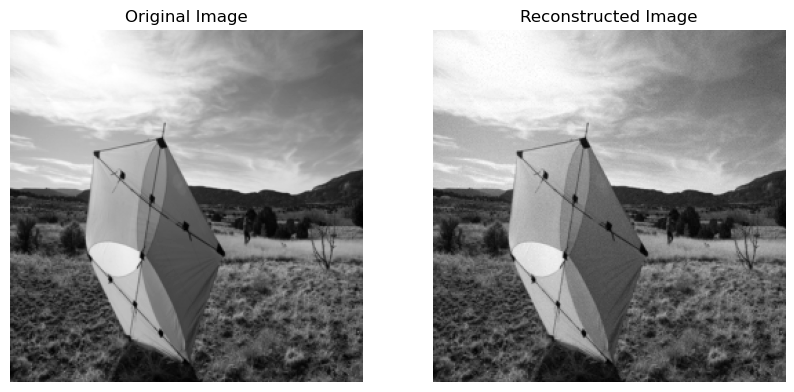

In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        self.fc1 = nn.Linear(256 * 256, 512)
        self.fc21 = nn.Linear(512, latent_dim) 
        self.fc22 = nn.Linear(512, latent_dim)  

        self.fc3 = nn.Linear(latent_dim, 512)
        self.fc4 = nn.Linear(512, 256 * 256)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        x = x.view(-1, 256 * 256)  
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE(latent_dim=2).to(device)

def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 256 * 256), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

image_path = "C:/Users/hegde/Downloads/Dl assignment/train2017/000000572909.jpg"
image = Image.open(image_path).convert('RGB')
grayscale_img = image.convert('L')
resize_transform = Resize((256, 256))
resized_image = resize_transform(grayscale_img)
tensor_image = ToTensor()(resized_image).unsqueeze(0).to(device)  
def train(model, data, optimizer, num_epochs=50):
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

train(model, tensor_image, optimizer)

def visualize_reconstruction(model, data):
    model.eval()
    with torch.no_grad():
        recon_batch, _, _ = model(data)
        recon_image = recon_batch.view(256, 256).cpu().numpy()
        original_image = data.view(256, 256).cpu().numpy()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(recon_image, cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')
    plt.show()
visualize_reconstruction(model, tensor_image)

Grayscale image can be reconstruct easily 
1. Model Architecture:
The VAE has a neural network with two main parts: an encoder and a decoder.
Encoder: It takes the input image (reshaped into a flat vector), passes it through a fully connected (FC) layer, and produces two outputs: the mean (mu) and log-variance (logvar). These are used to define a probability distribution over the latent space.
Decoder: This part takes a sample from the latent space (derived from mu and logvar), transforms it back using fully connected layers, and reconstructs the image.
2. Latent Space:
The latent space (with dimensionality latent_dim, here set to 2) represents the compressed form of the image. It encodes the important features of the image in a lower-dimensional space.
The latent space helps the VAE to learn a compact, abstract representation of the input data.
3. Reparameterization Trick:
During training, the VAE samples from the latent space using the mean (mu) and the log-variance (logvar). To allow backpropagation through the random sampling, the reparameterization trick is used, which introduces a random noise eps that is multiplied by the standard deviation (derived from logvar), and added to the mean. This step ensures the network remains differentiable, enabling optimization through gradient descent.
4. Forward Pass:
The input image is first flattened into a 1D vector.
The encoder processes the image to compute the latent variables (mu and logvar).
A sample z is drawn from the latent space using the reparameterization trick.
The decoder takes this sample and reconstructs the image by outputting pixel values, which are reshaped back into the original image dimensions.
5. Loss Function:
The loss function for the VAE consists of two parts:
Reconstruction Loss (Binary Cross Entropy, BCE): Measures the difference between the original image and the reconstructed image. It encourages the model to generate images as close as possible to the original input.
KL Divergence Loss (KLD): Regularizes the distribution in the latent space, pushing it towards a standard normal distribution (with mean 0 and variance 1). This helps the VAE learn meaningful latent representations while avoiding overfitting to the training data.
6. Training:
During training, the model processes the input image, computes the loss, and updates its parameters using backpropagation and gradient descent (via the Adam optimizer).
After each epoch, the model refines its ability to encode and decode the images.
7. Visualization:
After training, the visualization function compares the original image and the reconstructed image.
The reconstructed image is expected to closely resemble the original image, demonstrating that the VAE successfully learned how to compress and reconstruct the image from the latent space.

vae on single image from the mscoco dataset (RGB)

Epoch 1/20, Loss: 138038.40625
Epoch 2/20, Loss: 1.810810884006275e+29
Epoch 3/20, Loss: 1.810810884006275e+29
Epoch 4/20, Loss: 1.810810884006275e+29
Epoch 5/20, Loss: 1.810810884006275e+29
Epoch 6/20, Loss: 1.810810884006275e+29
Epoch 7/20, Loss: 1.810810884006275e+29
Epoch 8/20, Loss: 1.810810884006275e+29
Epoch 9/20, Loss: 1.810810884006275e+29
Epoch 10/20, Loss: 1.810810884006275e+29
Epoch 11/20, Loss: 1.810810884006275e+29
Epoch 12/20, Loss: 1.810810884006275e+29
Epoch 13/20, Loss: 1.810810884006275e+29
Epoch 14/20, Loss: 1.810810884006275e+29
Epoch 15/20, Loss: 1.810810884006275e+29
Epoch 16/20, Loss: 1.810810884006275e+29
Epoch 17/20, Loss: 1.810810884006275e+29
Epoch 18/20, Loss: 1.810810884006275e+29
Epoch 19/20, Loss: 1.810810884006275e+29
Epoch 20/20, Loss: 1.810810884006275e+29


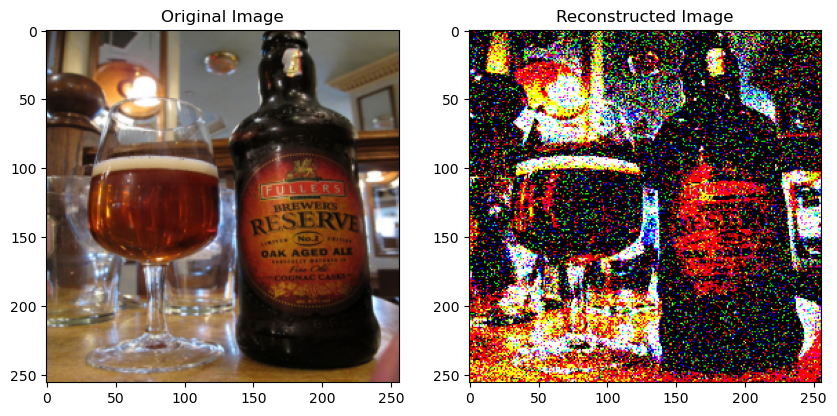

In [6]:
class VAE(nn.Module):
    def __init__(self, input_dim=256*256*3, hidden_dim=512, latent_dim=256):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim) 
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.8*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 256*256*3))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 256*256*3), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD
image_path = "C:/Users/hegde/Downloads/Dl assignment/train2017/000000571786.jpg"
img = Image.open(image_path).convert('RGB')  
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()  
])
tensor_image = transform(img).unsqueeze(0) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
tensor_image = tensor_image.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(model, data, optimizer, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

train(model, tensor_image, optimizer)

def visualize_reconstruction(model, data):
    model.eval()
    with torch.no_grad():
        recon, _, _ = model(data)
    recon_img = recon.view(3, 256, 256).permute(1, 2, 0).cpu().numpy()  
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(data.view(3, 256, 256).permute(1, 2, 0).cpu().numpy()) 
    axes[0].set_title("Original Image")
    axes[1].imshow(recon_img)
    axes[1].set_title("Reconstructed Image")
    plt.show()
visualize_reconstruction(model, tensor_image)

1. Model Architecture:
The input to the VAE is an RGB image with dimensions 256x256x3. This means the input layer of the model is adjusted to handle 3 color channels (Red, Green, and Blue).
The architecture has two parts: Encoder and Decoder.
Encoder: It takes the flattened input image (256x256x3) and encodes it into two vectors representing the mean (mu) and log-variance (logvar) of the latent space. These vectors capture the key information from the image in a compact latent representation.
Decoder: It takes a sample from the latent space (created using mu and logvar through the reparameterization trick), processes it through a series of layers, and reconstructs the image back to its original dimensions (256x256x3).
2. Latent Space:
The latent space has a dimensionality of 256, which serves as a compressed representation of the original image. The latent space captures essential features of the image while reducing the complexity of the data.
3. Reparameterization Trick:
The reparameterization trick introduces random noise eps into the latent space, ensuring the model can perform backpropagation through the sampling process. This is done by combining the mean (mu) and the standard deviation (derived from logvar) using the formula:
z=μ+ϵ⋅std
The random noise allows the VAE to explore different regions of the latent space during training, which helps in learning a smooth and continuous latent representation.
4. Loss Function:
The VAE uses a two-part loss function:
Reconstruction Loss (Binary Cross-Entropy, BCE): This measures the pixel-wise difference between the original image and the reconstructed image. Since the image is represented as values between 0 and 1, binary cross-entropy is used to compare the reconstruction and original data.
KL Divergence Loss (KLD): This encourages the learned latent distribution to approximate a standard normal distribution. It acts as a regularizer to ensure the latent space has a meaningful structure.
5. Training:
The model is trained over multiple epochs using an optimizer (Adam in this case). During each epoch, the input image is encoded into the latent space, reconstructed, and the loss is computed. The optimizer updates the model's parameters to minimize the total loss (reconstruction + KL divergence).
6. Visualization:
After training, the original image and the reconstructed image are displayed side by side for comparison.
The original image is shown as a reference.
The reconstructed image is the output of the VAE, which is reshaped and displayed in RGB format.
7. Adaptation for RGB:
The model is adapted to handle RGB images by:
Adjusting the input dimension (256x256x3 pixels) to accommodate three color channels.
Reshaping and handling the output from the decoder so it properly represents an RGB image (with three channels).
Using the appropriate transformation (permute) to display the reconstructed image in RGB format.

CNN form

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

Epoch 1/20, Loss: 138568.5
Epoch 2/20, Loss: 138287.875
Epoch 3/20, Loss: 137709.75
Epoch 4/20, Loss: 136435.734375
Epoch 5/20, Loss: 132558.359375
Epoch 6/20, Loss: 138913.296875
Epoch 7/20, Loss: 126839.4140625
Epoch 8/20, Loss: 128846.6015625
Epoch 9/20, Loss: 127565.9765625
Epoch 10/20, Loss: 124120.0390625
Epoch 11/20, Loss: 118840.9921875
Epoch 12/20, Loss: 119260.703125
Epoch 13/20, Loss: 117451.4296875
Epoch 14/20, Loss: 118693.7109375
Epoch 15/20, Loss: 117545.234375
Epoch 16/20, Loss: 122168.4921875
Epoch 17/20, Loss: 122532.703125
Epoch 18/20, Loss: 116260.046875
Epoch 19/20, Loss: 116700.0390625
Epoch 20/20, Loss: 115362.9140625


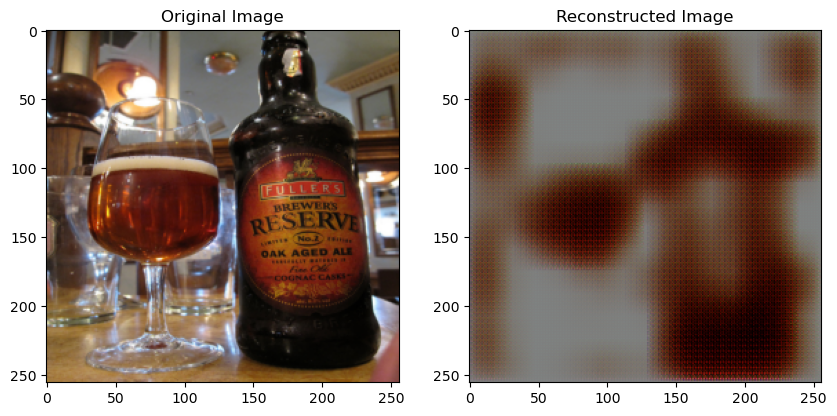

In [3]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=256):
        super(ConvVAE, self).__init__()             
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 128x128
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 8x8
            nn.ReLU(),
        )        
        self.fc_mu = nn.Linear(512 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(512 * 8 * 8, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 512 * 8 * 8)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def decode(self, z):
        h = self.fc_decode(z).view(-1, 512, 8, 8) 
        return self.decoder(h)
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD
image_path = "C:/Users/hegde/Downloads/Dl assignment/train2017/000000571786.jpg"
img = Image.open(image_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
tensor_image = transform(img).unsqueeze(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvVAE().to(device)
tensor_image = tensor_image.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(model, data, optimizer, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')
train(model, tensor_image, optimizer)

def visualize_reconstruction(model, data):
    model.eval()
    with torch.no_grad():
        recon, _, _ = model(data)
    recon_img = recon.squeeze().permute(1, 2, 0).cpu().numpy()    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(data.squeeze().permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Original Image")
    axes[1].imshow(recon_img)
    axes[1].set_title("Reconstructed Image")
    plt.show()
visualize_reconstruction(model, tensor_image)

 VAE uses a deep convolutional encoder-decoder architecture for efficient image compression and reconstruction. The encoder consists of multiple convolutional layers (32, 64, 128, 256, 512 channels) that progressively reduce the input image to a latent representation. The latent space is sampled using the reparameterization trick, allowing backpropagation through stochastic layers. The decoder reconstructs the image using transposed convolutional layers, expanding the latent vector back to the original image size. The loss function combines reconstruction loss (measuring image fidelity) and KL divergence (ensuring a smooth latent space). This model captures intricate features for high-quality image generation and reconstruction.

Epoch 1/20, Loss: 149757.078125
Epoch 2/20, Loss: 4216209.0
Epoch 3/20, Loss: 210351.75
Epoch 4/20, Loss: 141307.125
Epoch 5/20, Loss: 138316.234375
Epoch 6/20, Loss: 138752.921875
Epoch 7/20, Loss: 135252.671875
Epoch 8/20, Loss: 131202.78125
Epoch 9/20, Loss: 131177.4375
Epoch 10/20, Loss: 132661.640625
Epoch 11/20, Loss: 131942.71875
Epoch 12/20, Loss: 130433.625
Epoch 13/20, Loss: 126924.7265625
Epoch 14/20, Loss: 123713.34375
Epoch 15/20, Loss: 136265.21875
Epoch 16/20, Loss: 128123.953125
Epoch 17/20, Loss: 141750.1875
Epoch 18/20, Loss: 159326.984375
Epoch 19/20, Loss: 175571.8125
Epoch 20/20, Loss: 187745.4375


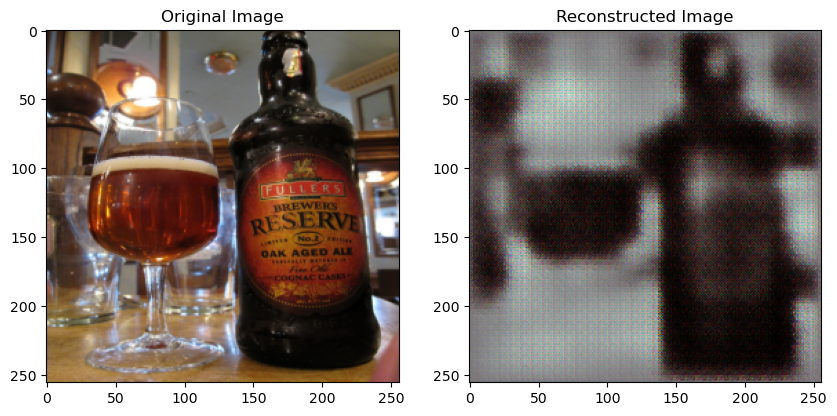

In [5]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=256):
        super(ConvVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        
        self.fc_mu = nn.Linear(512 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(512 * 8 * 8, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 512 * 8 * 8)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),   
            nn.Sigmoid(),
        )
        
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1) 
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def decode(self, z):
        h = self.fc_decode(z).view(-1, 512, 8, 8) 
        return self.decoder(h)
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD
    
image_path = "C:/Users/hegde/Downloads/Dl assignment/train2017/000000571786.jpg"
img = Image.open(image_path).convert('RGB')  
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()  
])
tensor_image = transform(img).unsqueeze(0)  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tensor_image = tensor_image.to(device)
latent_dim = 256
model = ConvVAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
def train(model, data, optimizer, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar, beta=1.0)
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')
train(model, tensor_image, optimizer)

def visualize_reconstruction(model, data):
    model.eval()
    with torch.no_grad():
        recon, _, _ = model(data)
    recon_img = recon.view(3, 256, 256).permute(1, 2, 0).cpu().numpy()      
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(data.view(3, 256, 256).permute(1, 2, 0).cpu().numpy()) 
    axes[0].set_title("Original Image")
    axes[1].imshow(recon_img)
    axes[1].set_title("Reconstructed Image")
    plt.show()
visualize_reconstruction(model, tensor_image)

Encoder: Convolutional layers (3–5) with Batch Normalization, LeakyReLU activation, and max-pooling to downsample progressively.
Latent Space: Fully connected layers for mu and logvar after flattening the output from the convolutional encoder.
Decoder: Transpose convolutional layers (3–5) with BatchNorm, LeakyReLU, and upsampling to recover the spatial dimensions, ending with a Sigmoid output.
it is a combination of multiple convolutional and upsampling layers to enhance reconstruction. This is in line with the PyTorch model’s goal of capturing detailed image structure through dimensionality reduction and then upsampling to the original resolution.